In [1]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Simulation parameters
RUNS = 100
NETWORK_FILE = "./networks/network_15_6.pkl"
FILEPATH_CSV = "./simulation_results/avg_rmse.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 500
q = 9.5e-5  # Process noise intensity
r = 5  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

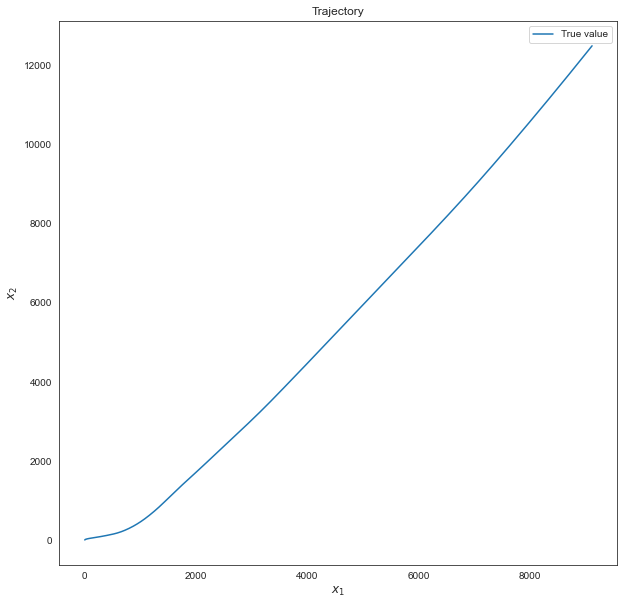

In [4]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [5]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(20 * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    # traj.simulate(ndat, INIT_STATE)
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

In [6]:
# kfn.draw_network()

In [7]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

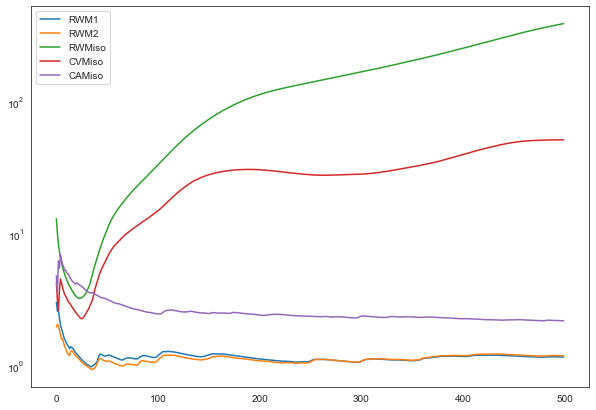

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 0], label="RWM1")
plt.plot(rmse_rwm2[:, 0], label="RWM2")

plt.plot(rmse_rwmnc[:, 0], label="RWMiso")
plt.plot(rmse_cvmnc[:, 0], label="CVMiso")
plt.plot(rmse_camnc[:, 0], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

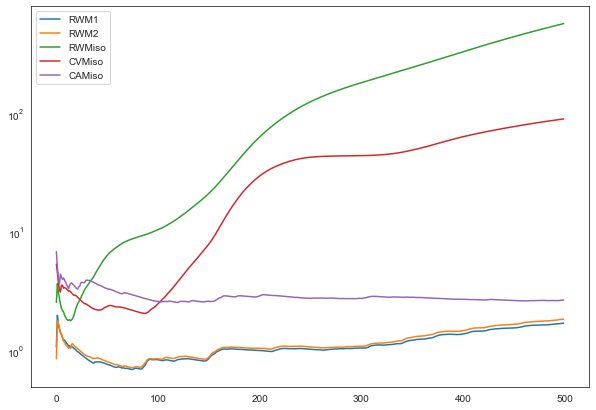

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 1], label="RWM1")
plt.plot(rmse_rwm2[:, 1], label="RWM2")

plt.plot(rmse_rwmnc[:, 1], label="RWMiso")
plt.plot(rmse_cvmnc[:, 1], label="CVMiso")
plt.plot(rmse_camnc[:, 1], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [10]:
# CSV column labels
cols = []
for n in chain(kfn._txt_labels, ["RWM_NC", "CVM_NC", "CAM_NC"]):
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

data = rmse_network(kfn, traj, ndat, 2, rwmnc, cvmnc, camnc)

In [11]:
# Generate CSV files
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_1_x1,RWM_1_x2,CVM_1_x1,CVM_1_x2,CVM_2_x1,CVM_2_x2,CVM_3_x1,CVM_3_x2,CVM_4_x1,CVM_4_x2,...,CAM_4_x1,CAM_4_x2,CAM_5_x1,CAM_5_x2,RWM_NC_x1,RWM_NC_x2,CVM_NC_x1,CVM_NC_x2,CAM_NC_x1,CAM_NC_x2
0,3.025099,1.073210,1.080220,1.762584,1.495359,1.387873,1.350396,1.704300,1.354571,1.672182,...,1.417026,1.600532,0.821130,1.627654,13.025679,2.556687,4.332968,5.377842,4.807569,6.870008
1,2.601306,1.985168,1.742116,1.841477,1.974202,2.090166,1.855791,2.090631,1.980939,1.983353,...,1.605005,1.937395,1.327928,1.797397,10.124405,3.676805,3.167075,4.554508,3.589113,5.061796
2,2.631116,1.642569,1.683107,1.861954,1.983661,1.995614,1.878508,1.973091,1.768720,1.892854,...,2.020296,1.691701,2.053707,1.566680,8.397506,3.110646,2.630090,3.727256,6.245046,4.133471
3,2.301881,1.511697,1.956984,1.634662,2.033392,1.731768,1.935335,1.709718,1.803398,1.641897,...,2.039163,1.530471,2.181293,1.384614,7.389284,2.759023,3.736542,3.308511,5.509874,3.658539
4,2.070182,1.437915,1.772826,1.494008,1.822737,1.561472,1.735943,1.559749,1.626976,1.522933,...,1.831017,1.419521,1.951397,1.248525,6.655343,2.480700,4.562750,3.121789,6.963302,4.430384
